# Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not  
[Kaggle Competetion]('https://www.kaggle.com/c/nlp-getting-started')

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read Data

In [2]:
train_set = pd.read_csv('kaggle-NLP-train.csv')
test_set = pd.read_csv('kaggle-NLP-test.csv')

In [3]:
train_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_set.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
train_set.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Creating a new column which will be the number of words in the text column**

In [7]:
train_set['text length'] = train_set['text'].apply(len)

In [8]:
train_set.head()

,id,keyword,location,text,target,text length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [9]:
train_set.groupby('target').describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                text length                                                   \
            max       count        mean        std   min   25%    50%    75%   
target                                                                         
0       10848.0      4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0   
1       10873.0      3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0   

               
          max  
target         
0       157.0  
1       151.0

## Exploratory Data Analysis

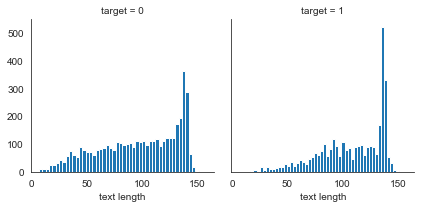

In [10]:
sns.set_style('white')
g = sns.FacetGrid(train_set, col='target')
g.map(plt.hist, 'text length', bins=50)

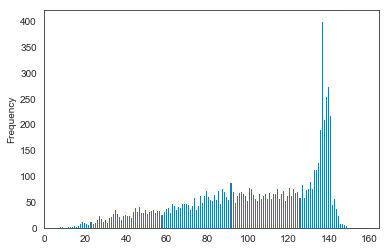

In [11]:
train_set['text length'].plot.hist(bins=150)

In [12]:
train_set['text length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text length, dtype: float64

In [13]:
train_set[train_set['text length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

First approach with custom Analyzer

In [14]:
import string
import re
import nltk
from nltk.corpus import stopwords

Now let's "tokenize" these text

In [15]:
def text_process(text):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of clean text words
    .
    .
    .
    """
    
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    nopunc = re.sub('\[.*?\]', '', nopunc)
    nopunc = re.sub("\\W"," ",nopunc)
    nopunc = re.sub('https?://\S+|www\.\S+', '', nopunc)
    nopunc = re.sub('<.*?>+', '', nopunc)
    nopunc = re.sub('[%s]' % re.escape(string.punctuation), '', nopunc)
    nopunc = re.sub('\n', '', nopunc)
    nopunc = re.sub('\w*\d\w*', '', nopunc)
    return [word for word in nopunc.split() if word not in stopwords.words('english')]

In [16]:
train_set['text'].head().apply(text_process)

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

### Vectorization

Now lets convert each text, represented as a list of tokens (lemmas) above, into a vector

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
# bow: bag of words
bow_transformer = CountVectorizer(analyzer=text_process).fit(train_set['text'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

17046


Now lets use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of text.

In [19]:
text_bow_train = bow_transformer.transform(train_set['text'])
text_bow_test = bow_transformer.transform(test_set['text'])

print('Shape of Sparse Matrix train: ', text_bow_train.shape)
print('Amount of Non-Zero occurences train: ', text_bow_train.nnz)
print('\n')
print('Shape of Sparse Matrix test: ', text_bow_test.shape)
print('Amount of Non-Zero occurences test: ', text_bow_test.nnz)

Shape of Sparse Matrix train:  (7613, 17046)
Amount of Non-Zero occurences train:  67874


Shape of Sparse Matrix test:  (3263, 17046)
Amount of Non-Zero occurences test:  24631


### Use TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer_train = TfidfTransformer().fit(text_bow_train)
tfidf_transformer_test = TfidfTransformer().fit(text_bow_test)

In [21]:
text_tfidf_train = tfidf_transformer_train.transform(text_bow_train)
text_tfidf_test = tfidf_transformer_test.transform(text_bow_test)
print(text_tfidf_train.shape)
print(text_tfidf_test.shape)

(7613, 17046)
(3263, 17046)


### Training a model using naive_bayes classifier 

In [22]:
from sklearn.naive_bayes import MultinomialNB
disaster_detect_model = MultinomialNB().fit(text_tfidf_train, train_set['target'])

In [23]:
print('predicted:', disaster_detect_model.predict(text_tfidf_test)[:5])

predicted: [1 0 1 1 1]


In [24]:
test_set.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
predictions = disaster_detect_model.predict(text_tfidf_test)

**Submission**

In [26]:
sample_submission = pd.read_csv("sample_submission.csv")

In [27]:
sample_submission["target"] = predictions

In [28]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [29]:
sample_submission.to_csv("submission.csv", index=False)

In [31]:
test_set.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [33]:
predictions.tail()

AttributeError: 'numpy.ndarray' object has no attribute 'tail'